# Distribution function for generic density profiles

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
from scipy.integrate import quad, cumtrapz, simps
from tqdm import tqdm

import matplotlib as mpl
mpl.rcParams['font.size'] = 18.0

In [3]:
G_N = 4.302e-3 #(km/s)^2 pc/Msun

In [4]:
#We'll normalise the AMC such that it has unit radius.
rho_AMC = 1.0
R_AMC = 1.0

R_list = np.geomspace(1e-9, 1e3, 2000)*R_AMC

### Specifying the density profile

**Edit this cell with density profile function.** The overall normalisation of the density profile doesn't matter for these calculations. Also don't worry about truncating the profile at $r = R_\mathrm{AMC}$ - that's done automatically later. Here you can see an example of an NFW profile with concentration $c = 100$.

In [5]:
#This will be the name of the profile to be used in the other parts of the code later
ID_str = "NFW_test"

@np.vectorize
def rho(r):
    c = 100
    r_s = R_AMC/c
    x = r/r_s
    return rho_AMC/(x*(1+x)**2)

-------------------------
### Calculating enclosed masses and potentials

In [6]:
def M_enc(r):
    integrand = lambda x: 4*np.pi*x**2*rho(x)
    return quad(integrand, 0, r, epsabs=1e-12)[0]

M_AMC = M_enc(R_AMC)
#print("M_AMC:", M_AMC)

M_list = 0.0*R_list
for i , R in enumerate(tqdm(R_list, desc="Calculating mass grid")):
    M_list[i] = M_enc(R)
    
M_interp = interpolate.interp1d(R_list, M_list, kind='linear', bounds_error=False, fill_value=(M_list[0], 0))

def psi_generic(r):
    integrand = lambda x: G_N*M_interp(x)/x**2
    return quad(integrand, r, 1e3*R_AMC, epsabs=1e-12, points=np.geomspace(1e-9, 1e3, 13))[0]

psi_list = 0.0*R_list
for i , R in enumerate(tqdm(R_list, desc="Calculating psi grid")):
    psi_list[i] = psi_generic(R)
psi_interp = interpolate.interp1d(R_list, psi_list, bounds_error=False, fill_value=(psi_list[0], 0))

@np.vectorize
def psi(r):
    psi_outer = G_N*M_AMC/np.clip(r, R_AMC, 1e30)
    return np.clip(psi_interp(r) - psi_interp(R_AMC), 0, 1e30) + psi_outer


psi0 = G_N*M_AMC/R_AMC

Calculating psi grid:   0%|          | 0/2000 [00:00<?, ?it/s]<ipython-input-6-caf3a381d32e>:16: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return quad(integrand, r, 1e3*R_AMC, epsabs=1e-12, points=np.geomspace(1e-9, 1e3, 13))[0]
Calculating psi grid:  59%|█████▊    | 1171/2000 [00:26<00:07, 110.30it/s]<ipython-input-6-caf3a381d32e>:16: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return quad(integrand, r, 1e3*R_AMC, epsabs=1e-12, points=np.geomspace(1e-9, 

In [7]:
rho_list = rho(R_list)
psi_list = psi(R_list)

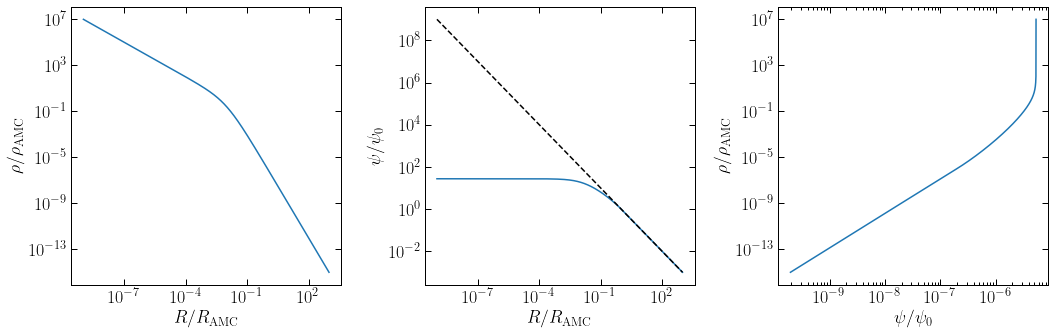

In [8]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

axes[0].loglog(R_list, rho_list)
axes[0].set_xlabel(r"$R/R_\mathrm{AMC}$")
axes[0].set_ylabel(r"$\rho/\rho_\mathrm{AMC}$")

axes[1].loglog(R_list, psi_list/psi0)
axes[1].loglog(R_list, (G_N*M_AMC/R_list)/psi0, 'k--')
axes[1].set_xlabel(r"$R/R_\mathrm{AMC}$")
axes[1].set_ylabel(r"$\psi/\psi_0$")

axes[2].loglog(psi_list, rho_list)
axes[2].set_xlabel(r"$\psi/\psi_0$")
axes[2].set_ylabel(r"$\rho/\rho_\mathrm{AMC}$")

plt.tight_layout()

plt.show()

### Generating the distribution function

In [9]:
rho_of_psi = interpolate.InterpolatedUnivariateSpline(psi_list[::-1], rho_list[::-1])
d2rho = rho_of_psi.derivative(n=2)

In [10]:
def f(eps):
    integ = lambda x: d2rho(x)/(np.sqrt(eps - x))
    result = quad(integ, 0, eps, epsrel=1e-6)[0]
    return result/(np.sqrt(8)*np.pi**2) 

In [11]:
eps_list = psi(R_list)

In [12]:
f_list = 0.0*eps_list
for i, eps in enumerate(tqdm(eps_list, desc = "Calculating distribution function grid")):
    f_list[i] = f(eps)

Calculating distribution function grid:   0%|          | 0/2000 [00:00<?, ?it/s]<ipython-input-10-3c68b39ff30e>:3: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result = quad(integ, 0, eps, epsrel=1e-6)[0]
Calculating distribution function grid:   0%|          | 10/2000 [00:00<00:48, 41.42it/s]<ipython-input-10-3c68b39ff30e>:3: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  result = quad(integ, 0, eps, epsrel=1e-6)[0]
Calculating distribution function grid:   3%|▎         | 63/2000 [00:01<00:46, 41.34it/s]<ipython-input-10-3c68b39ff30e>:3: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the diffi

In [13]:
f_interp = interpolate.interp1d(eps_list, f_list, bounds_error=False, fill_value = 0.0)

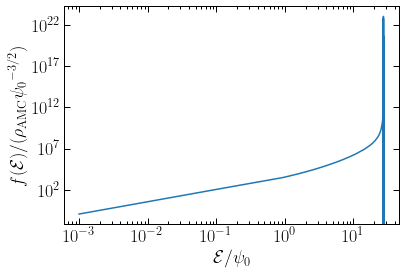

In [14]:
plt.figure()

plt.loglog(eps_list/psi0, f_list)

plt.xlabel(r"$\mathcal{E}/\psi_0$")
plt.ylabel(r"$f(\mathcal{E})/(\rho_\mathrm{AMC}\psi_0{}^{-3/2})$")

plt.show()

### Checking the distribution function

We reconstruct the density profile from the distribution, just to check for self-consistency. For $r \gg R_\mathrm{AMC}$, the density profile might diverge, because our grid of $r$ values stops at some point. This isn't too important - we'll mostly be interested in $r \leq R_\mathrm{AMC}$.

In [15]:
def v_max(r):
    return np.sqrt(2*psi(r))

def get_density(r):
    v_max = np.sqrt(2*psi(r))
    v_list = np.linspace(0, v_max, 100)
    f_list = f_interp(psi(r)-0.5*v_list**2)
    return 4*np.pi*np.trapz(v_list**2*f_list, v_list)

In [16]:
r_check = np.geomspace(1e-5, 1e3, 1000)
dens_list = 0.0*r_check

for i, r in enumerate(tqdm(r_check, desc="Checking density profile")):
    dens_list[i] = get_density(r)

Checking density profile: 100%|██████████| 1000/1000 [00:00<00:00, 2565.84it/s]


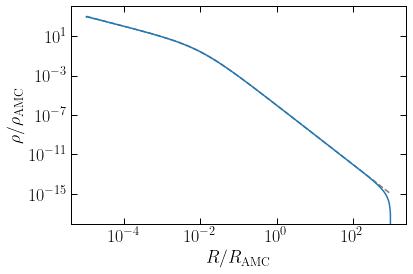

In [17]:
plt.figure()

plt.loglog(r_check, rho(r_check), linestyle='--', color='grey')
plt.loglog(r_check, dens_list)
#plt.xlim(0, 10)
plt.xlabel(r"$R/R_\mathrm{AMC}$")
plt.ylabel(r"$\rho/\rho_\mathrm{AMC}$")
plt.show()

### Checking the AMC properties

Here, we'll double check that we get the correct mass for the AMC, then calculate the $\alpha^2$, $\beta$ and $\kappa$ parameters which parametrise the mean radius, potential energy and kinetic energy of the AMC.

**Total Mass**

In [18]:
def trapz_int(integrand, a, b, numpoints=1000):
    x = np.linspace(a, b, numpoints)
    y = integrand(x)
    return np.trapz(y, x)

In [19]:
def I_nocut(x):
    integ = lambda eps: np.sqrt(2*(psi(x) - eps))*f_interp(eps)
    #return quad(integ, 0,  psi(x), epsabs=1e-6)[0]
    return trapz_int(integ, 0,  psi(x))

def calcMass():
    x_range = np.geomspace(1e-9, 1, 1000)
    I_integ = 0.0*x_range
    for j, x in enumerate(x_range):
        I_integ[j] = I_nocut(x)
    return 16*np.pi**2*np.trapz(I_integ*x_range**2, x_range)

In [20]:
M_total = calcMass()
#print(M_total/M_AMC)
correction_factor = M_AMC/M_total
#print(correction_factor)
#This correction factor corrects for the fact that the calculation does not give exactly the correct mass (to within ~1%)
#So if we're using the 'true' mass M_AMC, we should correct the following calculations by this factor

**Mean radius squared**

In [21]:
#Here, we calculate alpha^2, as defined in the paper
r_sq_integ = lambda x: x**2*rho(x)*4*np.pi*x**2
alpha_sq = quad(r_sq_integ, 0, 1, epsabs=1e-12)[0]/quad(lambda x: rho(x)*4*np.pi*x**2, 0, 1, epsabs=1e-12)[0]
print("alpha^2 = ", alpha_sq) #alpha^2

alpha^2 =  0.13276763333168884


**Kinetic Energy**

In [22]:
def I_kin(x):
    integ = lambda eps: 0.5*(np.sqrt(2*(psi(x) - eps)))**3*f_interp(eps)
    #return quad(integ, 0, psi(x), epsabs=1e-6)[0]
    return trapz_int(integ, 0, psi(x))

def calcEkin():
    x_range = np.geomspace(1e-9, 1, 1000)
    I_integ = 0.0*x_range
    for j, x in enumerate(x_range):
        I_integ[j] = I_kin(x)
    return correction_factor*16*np.pi**2*np.trapz(I_integ*x_range**2, x_range)

In [23]:
E_kin = calcEkin()
kappa = 2*E_kin/(G_N*M_AMC**2/R_AMC)
print("kappa = ", kappa)

kappa =  3.5249610552168633


**Potential Energy**

In [24]:
#Note the factor of 1/2 to prevent double-counting.
def I_pot(x):
    integ = lambda eps: 0.5*psi(x)*np.sqrt(2*(psi(x) - eps))*f_interp(eps)
    #return quad(integ, 0, psi(x), epsabs=1e-6)[0]
    return trapz_int(integ, 0, psi(x))

def calcEpot():
    x_range = np.geomspace(1e-9, 1, 1000)
    I_integ = 0.0*x_range
    for j, x in enumerate(x_range):
        I_integ[j] = I_pot(x)
    return correction_factor*16*np.pi**2*np.trapz(I_integ*x_range**2, x_range)

In [25]:
E_bind = calcEpot()
beta = E_bind/(G_N*M_AMC**2/R_AMC)
print("beta = ", beta)

beta =  3.456441744057001


In [26]:
E_total = E_kin - E_bind
print(E_total/(G_N*M_AMC**2/R_AMC))

-1.6939612164485693


### Calculating the AMC Response Functions

We now calculate the response of the AMC (in terms of energy and mass loss) to energy injections.

**Mass Loss**

The total mass is:

$$ M(< \Delta \eta) = 16\pi^2 \rho_\mathrm{AMC}  R_\mathrm{AMC}^3 \int_{0}^{1} x^2 I(y, \Delta \eta)\,\mathrm{d}y$$

Although actually, note that $\Delta \mathcal{E} = (\Delta E/M) \times r^2/\langle r^2 \rangle$

In [27]:
def I_loss(x, delta_eps):
    integ = lambda eps: np.sqrt(2*(psi(x) - eps))*f_interp(eps)
    #return quad(integ, 0, np.minimum(delta_eps, psi(x)), epsrel=1e-4)[0]
    return trapz_int(integ, 0, np.minimum(delta_eps, psi(x)))

def I_remain(x, delta_eps):
    if (delta_eps >= psi(x)):
        return 0
    else:
        integ = lambda eps: np.sqrt(2*np.clip(psi(x) - eps, 0, 1e30))*f_interp(eps)
        #eps_range = np.sort(psi(x) - np.geomspace(1e-10, psi(x) - delta_eps, 100))
        #print(eps_range/psi(x))
        eps_range = psi(x)*np.sort(1 - np.geomspace(1e-9, 1 - delta_eps/psi(x), 200))
        eps_range = np.sort(np.append(eps_range, np.linspace(delta_eps*1.0001, psi(x)), 200))
        #eps_range = np.linspace(delta_eps, psi(x), 1000)
        #print(eps_range)#,integ(eps_range))
        #print(psi(x) - eps_range)
        return np.trapz(integ(eps_range), eps_range)
        
    #else:
    #    i
    #    return quad(integ, delta_eps, psi(x), epsrel=1e-4)[0]

def I_remain_corr(x, delta_eps, psi_fun):
    integ = lambda eps: np.sqrt(2*(psi(x) - eps))*f_interp(eps)
    return quad(integ, np.minimum(delta_eps, psi_fun(x)), psi_fun(x), epsrel=1e-4)[0]

def calcMassLoss(delta_eps):
    x_range = np.geomspace(1e-6, 1, 100)
    I_integ = 0.0*x_range
    for j, x in enumerate(x_range):
        I_integ[j] = I_loss(x, delta_eps*x**2/alpha_sq)
    return 16*np.pi**2*np.trapz(I_integ*x_range**2, x_range)

In [28]:
deltaE_list = np.geomspace(1e-6, 1e4, 200)*E_bind

In [29]:
deltaM_list = 0.0*deltaE_list

for i, deltaE in enumerate(tqdm(deltaE_list)):
    deltaM_list[i] = calcMassLoss(deltaE/M_AMC)

100%|██████████| 200/200 [00:07<00:00, 25.55it/s]


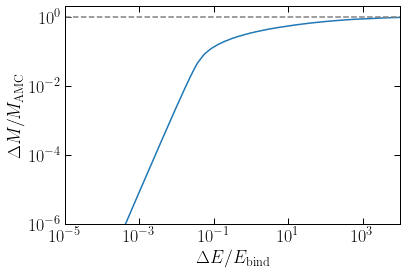

In [30]:
plt.figure()
plt.loglog(deltaE_list/E_bind, deltaM_list/M_AMC)

plt.xlim(1e-5, 1e4)
plt.ylim(1e-6, 2)

plt.xlabel(r"$\Delta E/E_\mathrm{bind}$")
plt.ylabel(r"$\Delta M/M_\mathrm{AMC}$")

plt.axhline(1.0, linestyle='--', color='grey')
plt.show()

**Energy Ejection and Remaining**

In [31]:
def calcEnergyEjected(delta_eps):
    x_range = np.geomspace(1e-6, 1, 100)
    I_integ = 0.0*x_range
    for j, x in enumerate(x_range):
        I_integ[j] = I_loss(x, delta_eps*x**2/alpha_sq)
    return 16*np.pi**2*np.trapz((delta_eps*x_range**2/alpha_sq)*I_integ*x_range**2, x_range)

In [32]:
E_ejec_list = 0.0*deltaE_list
for i, deltaE in enumerate(tqdm(deltaE_list)):
    E_ejec_list[i] = calcEnergyEjected(deltaE/M_AMC)

100%|██████████| 200/200 [00:07<00:00, 25.04it/s]


In [33]:
def calcEnergyRemain(delta_eps):
    x_range = np.geomspace(1e-6, 1, 100)
    I_integ = 0.0*x_range
    for j, x in enumerate(x_range):
        I_integ[j] = I_remain(x, delta_eps*x**2/alpha_sq)
    return 16*np.pi**2*np.trapz((delta_eps*x_range**2/alpha_sq)*I_integ*x_range**2, x_range)

In [34]:
E_rem_list = 0.0*deltaE_list
for i, deltaE in enumerate(tqdm(deltaE_list)):
    E_rem_list[i] = calcEnergyRemain(deltaE/M_AMC)

100%|██████████| 200/200 [00:17<00:00, 11.63it/s]


In [35]:
f_ej_list = E_ejec_list/deltaE_list
f_rem_list = E_rem_list/deltaE_list
f_ej_fixed = np.append(f_ej_list[:100], 1-f_rem_list[100:]) #Fix numerical issues when f_ej is close to 0 or 1

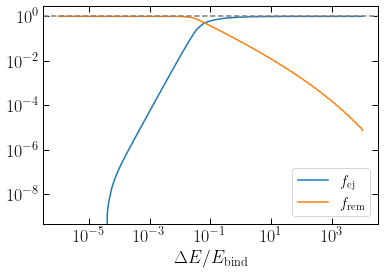

In [36]:
plt.figure()

plt.loglog(deltaE_list/E_bind, f_ej_list, label=r'$f_\mathrm{ej}$')
plt.loglog(deltaE_list/E_bind, f_rem_list, label=r'$f_\mathrm{rem}$')
plt.xlabel(r"$\Delta E/E_\mathrm{bind}$")
#plt.ylabel(r"$f_\mathrm{rem}$")

plt.legend(loc='best')

plt.axhline(1.0, linestyle='--', color='grey')

plt.show()

**Initial Energy of unbound particles**

We'll define the 'initial energy of the particles which will eventually be unbound' as:
$$E_i^\mathrm{unbound} = T_i^\mathrm{unbound} + E_{\mathrm{bind}, i} - E_{\mathrm{bind}, f}$$
where $T_i^\mathrm{unbound}$ is the total initial kinetic energy of the particles which will be unbound.

In [37]:
def calcFinalEbind(delta_eps):
    x_range = np.geomspace(1e-9, 1, 100)
    rho_final = 0.0*x_range
    #if (delta_eps > 0.1*E_bind):
    for j, x in enumerate(x_range):
        rho_final[j] = 4*np.pi*I_remain(x, delta_eps*x**2/alpha_sq)
    #else:
    #    for j, x in enumerate(x_range):
    #        rho_final[j] = rho(x) - 4*np.pi*I_loss(x, delta_eps*x**2/x2_avg)
    
    Menc = cumtrapz(4*np.pi*rho_final*x_range**2, x_range, initial=0.0)
    return G_N*np.trapz((Menc/x_range)*4*np.pi*rho_final*x_range**2, x_range)

In [38]:
print(calcFinalEbind(E_bind/M_AMC))

2.6129643474574658e-11


Calculating the 'first order' change in binding energy

In [39]:
#Note the factor of 1/2 to prevent double-counting.
def I_pot_loss(x, delta_eps):
    integ = lambda eps: 0.5*psi(x)*np.sqrt(2*(psi(x) - eps))*f_interp(eps)
    #return quad(integ, 0, np.minimum(delta_eps, psi(x)), epsrel=1e-4)[0]
    return trapz_int(integ, 0, np.minimum(delta_eps, psi(x)))

def calcEpot_loss(delta_eps):
    x_range = np.geomspace(1e-9, 1, 1000)
    I_integ = 0.0*x_range
    for j, x in enumerate(x_range):
        I_integ[j] = I_pot_loss(x, delta_eps*x**2/alpha_sq)
    return 16*np.pi**2*np.trapz(I_integ*x_range**2, x_range)

In [40]:
calcFinalEbind(1e-5*E_bind/M_AMC)/E_bind

1.007139443336415

In [41]:
Ebind1_list = 0.0*deltaE_list
Ebind2loss_list = 0.0*deltaE_list
for i, deltaE in enumerate(tqdm(deltaE_list)):
    Ebind1_list[i] = calcFinalEbind(deltaE/M_AMC)
    Ebind2loss_list[i] = calcEpot_loss(deltaE/M_AMC)

100%|██████████| 200/200 [02:00<00:00,  1.66it/s]


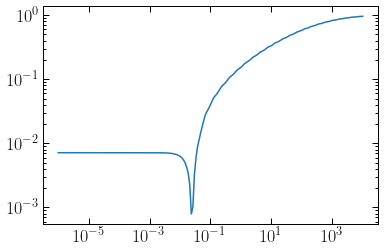

In [42]:
plt.figure()
plt.loglog(deltaE_list/E_bind, np.abs(1-Ebind1_list/E_bind), label="Full")
plt.show()

The change in binding energy can be very well approximated as:
$$ \Delta E_\mathrm{bind} = (1 - \frac{1}{2}\frac{\Delta M}{M}) \times \int_\mathrm{removed} \psi(r) f(r, v)\,\mathrm{d}^3 r$$

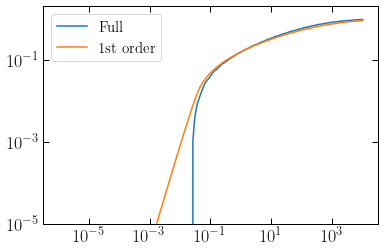

In [43]:
plt.figure()

plt.loglog(deltaE_list/E_bind, 1 - Ebind1_list/E_bind, label="Full")
plt.loglog(deltaE_list/E_bind, 2*(1 - 0.5*deltaM_list/M_AMC)*Ebind2loss_list/E_bind, label="1st order")
plt.ylim(1e-5, 2)
plt.legend()

plt.show()

<ipython-input-44-b95313a27586>:3: RuntimeWarning: divide by zero encountered in true_divide
  plt.loglog(deltaE_list/E_bind,(1-Ebind1_list/E_bind)/(Ebind2loss_list/E_bind))


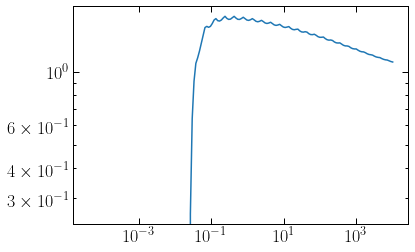

In [44]:
plt.figure()

plt.loglog(deltaE_list/E_bind,(1-Ebind1_list/E_bind)/(Ebind2loss_list/E_bind))

plt.show()

In [45]:
def I_kin_loss(x, delta_eps):
    integ = lambda eps: 0.5*(np.sqrt(2*(psi(x) - eps)))**3*f_interp(eps)
    #return quad(integ, 0, np.minimum(delta_eps, psi(x)), epsrel=1e-4)[0]
    return trapz_int(integ, 0, np.minimum(delta_eps, psi(x)))

def calcEunbound_kin(delta_eps):
    x_range = np.geomspace(1e-9, 1, 100)*R_AMC
    I_integ = 0.0*x_range
    for j, x in enumerate(x_range):
        I_integ[j] = I_kin_loss(x, delta_eps*x**2/alpha_sq)
    return 16*np.pi**2*np.trapz(I_integ*x_range**2, x_range)

In [46]:
deltaU0 = -calcFinalEbind(0)- (-E_bind)
#print(FinalEbind0)
def calcEi_unbound(deltaE):
    T_i_ub = calcEunbound_kin(deltaE/M_AMC)
    deltaU = (-calcFinalEbind(deltaE/M_AMC)) - (-E_bind) - deltaU0
    #print(deltaU)
    return T_i_ub - (deltaU)

In [47]:
Ei_unbound_list = 0.0*deltaE_list
for i, deltaE in enumerate(tqdm(deltaE_list)):
    Ei_unbound_list[i] = calcEi_unbound(deltaE)

100%|██████████| 200/200 [00:25<00:00,  7.75it/s]


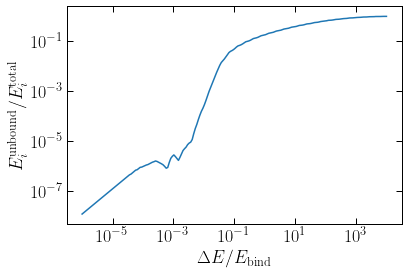

In [48]:
plt.figure()

plt.loglog(deltaE_list/E_bind, Ei_unbound_list/E_total)

plt.xlabel(r"$\Delta E/E_\mathrm{bind}$")
plt.ylabel(r"$E_i^\mathrm{unbound}/E_i^\mathrm{total}$")

plt.show()

In [49]:
E_final_list = E_total + deltaE_list*(1 - f_ej_fixed) -  Ei_unbound_list

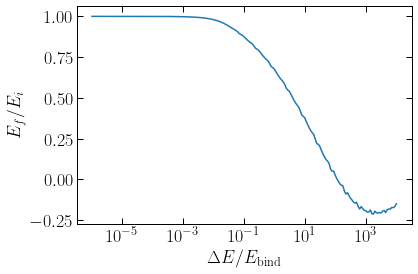

In [50]:
plt.figure()

plt.semilogx(deltaE_list/E_bind, E_final_list/E_total)

plt.xlabel(r"$\Delta E/E_\mathrm{bind}$")
plt.ylabel(r"$E_f/E_i$")

plt.show()

### Summary plot

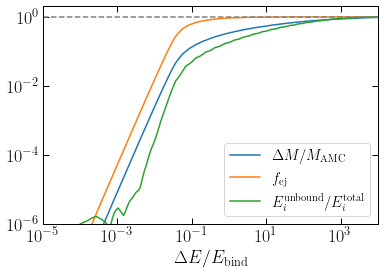

In [51]:
plt.figure()

plt.loglog(deltaE_list/E_bind, deltaM_list/M_AMC, label="$\Delta M/M_\mathrm{AMC}$")

plt.loglog(deltaE_list/E_bind, f_ej_fixed, label="$f_\mathrm{ej}$")

plt.loglog(deltaE_list/E_bind, Ei_unbound_list/E_total, label="$E_i^\mathrm{unbound}/E_i^\mathrm{total}$")

plt.axhline(1.0, linestyle='--', color='grey')

plt.xlabel(r"$\Delta E/E_\mathrm{bind}$")
#plt.ylabel(r"$E_i^\mathrm{unbound}/E_i^\mathrm{total}$")

plt.xlim(1e-5, 1e4)
plt.ylim(1e-6, 2)

plt.legend(loc='best')

plt.show()

In [70]:
#BJK: Explain here

In [71]:
dE_threshold = deltaE_list[deltaM_list/M_AMC >= 1e-8][0]/E_bind
if (dE_threshold < 1e-20):
    dE_threshold = 1e-6
print(dE_threshold)

8.11984499318401e-05


### Saving the output

In [72]:
hdrtxt = "Binding energy = beta*G_N*M_AMC^2/R_AMC\nColumns: deltaE/Ebind, deltaM/M, f_ej, E_i_unbound/E_i_total"

np.savetxt("../data/Perturbations_%s.txt"%(ID_str,), list(zip(deltaE_list/E_bind, deltaM_list/M_AMC, f_ej_fixed, np.clip(Ei_unbound_list/E_total, 0, 1e30))), header=hdrtxt)

In [73]:
hdrtxt = "alpha_sq, beta, kappa, dE_threshold"
np.savetxt("../data/AMC_parameters_%s.txt"%(ID_str,), (alpha_sq, beta, kappa, dE_threshold), header=hdrtxt)

In [74]:
print("DONE!")

DONE!
